In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np

import caustic

In [2]:
# initialization stuff for lenses
cosmology = caustic.FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustic.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)

In [3]:
N_planes = 10
N_lenses = 2 # per plane

z_plane = np.linspace(0.1, 1.0, N_planes)
planes = []

for p, z_p in enumerate(z_plane):
    lenses = []
    
    if p == N_planes // 2:
        lenses.append(
                caustic.NFW(
                    cosmology = cosmology, 
                    z_l = z_p,
                    x0 = torch.tensor(0.),
                    y0 = torch.tensor(0.),
                    m = torch.tensor(10**11),
                    c = torch.tensor(10.),
                    s = torch.tensor(0.001),
                )        
        )
    else:
        for _ in range(N_lenses):
            lenses.append(
                caustic.NFW(
                    cosmology = cosmology, 
                    z_l = z_p,
                    x0 = torch.tensor(np.random.uniform(-fov/2., fov/2.)),
                    y0 = torch.tensor(np.random.uniform(-fov/2., fov/2.)),
                    m = torch.tensor(10**np.random.uniform(8,9)),
                    c = torch.tensor(np.random.uniform(4,40)),
                    s = torch.tensor(0.001),
                )
            )

    planes.append(
        caustic.lenses.SinglePlane(z_l = z_p, cosmology = cosmology, lenses = lenses, name = f"plane {p}")
    )
    
lens = caustic.lenses.Multiplane(name = "multiplane", cosmology = cosmology, lenses = planes)

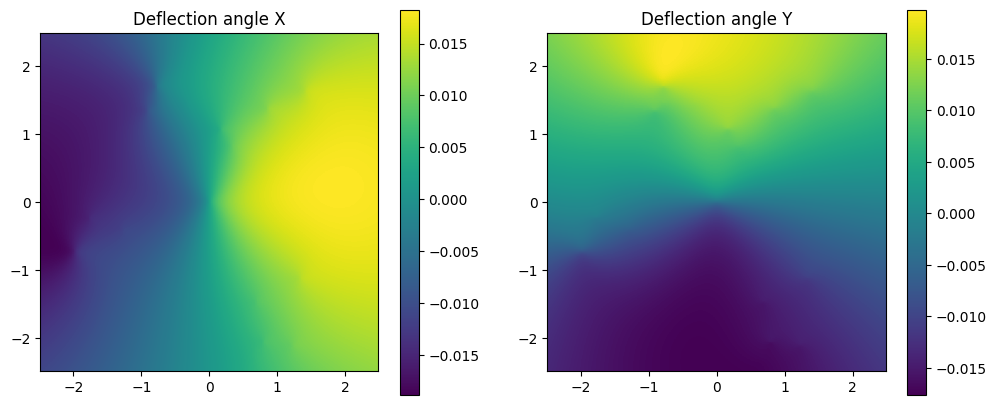

In [4]:
# Effective reduced deflection angles for the multiplane lens system
ax, ay = lens.effective_reduced_deflection_angle(thx, thy, z_s)

# Plot
fig, axarr = plt.subplots(1,2,figsize = (12,5))
im = axarr[0].imshow(ax, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
axarr[0].set_title("Deflection angle X")
plt.colorbar(im)
im = axarr[1].imshow(ay, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
axarr[1].set_title("Deflection angle Y")
plt.colorbar(im)
plt.show()